In [ ]:
# !pip install transformers --upgrade --q
# !pip install accelerate --q
# !pip install datasets --q

In [1]:
import time
start_time = time.time()
start_time

1682667602.612237

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
# !pip install scikit-surprise


In [4]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import pandas as pd
from collections import defaultdict

In [5]:
base_path = "data"

train = pd.read_csv(f'{base_path}/train.csv')
test = pd.read_csv(f'{base_path}/test.csv')
submission = pd.read_csv(f'{base_path}/sample_submission.csv', index_col='ID')

train.shape, test.shape, submission.shape

((871393, 10), (159621, 9), (159621, 1))

* ID : 샘플 고유 ID
* User-ID : 유저 고유 ID
* Book-ID : 도서 고유 ID
* 유저 정보
* Age : 나이
* Location : 지역
* 도서 정보
* Book-Title : 도서 명
* Book-Author : 도서 저자
* Year-Of-Publication : 도서 출판 년도 (-1일 경우 결측 혹은 알 수 없음):
* Publisher : 출판사
* Book-Rating : 유저가 도서에 부여한 평점 (0점 ~ 10점)

In [6]:
train.head()

,ID,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,TRAIN_000000,USER_00000,BOOK_044368,8,23.0,"sackville, new brunswick, canada",Road Taken,Rona Jaffe,2001.0,Mira
1,TRAIN_000001,USER_00000,BOOK_081205,8,23.0,"sackville, new brunswick, canada",Macbeth (New Penguin Shakespeare),William Shakespeare,1981.0,Penguin Books
2,TRAIN_000002,USER_00000,BOOK_086781,0,23.0,"sackville, new brunswick, canada",Waverley (Penguin English Library),Walter Scott,1981.0,Penguin Books
3,TRAIN_000003,USER_00000,BOOK_098622,0,23.0,"sackville, new brunswick, canada",Mother Earth Father Sky,Sue Harrison,1991.0,Avon
4,TRAIN_000004,USER_00000,BOOK_180810,8,23.0,"sackville, new brunswick, canada",She Who Remembers,Linda Lay Shuler,1989.0,Signet Book


In [7]:
test.head()

,ID,User-ID,Book-ID,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,TEST_000000,USER_00008,BOOK_047966,37.0,"vermilion, ohio, usa",Birds of Prey: A Novel of Suspense,J.A. Jance,2002.0,Avon
1,TEST_000001,USER_00008,BOOK_119494,37.0,"vermilion, ohio, usa",Midnight Voices,JOHN SAUL,2003.0,Ballantine Books
2,TEST_000002,USER_00008,BOOK_151775,37.0,"vermilion, ohio, usa",Breaking Free : A Prescription for Personal an...,David M. Noer,1996.0,Jossey-Bass
3,TEST_000003,USER_00008,BOOK_176255,37.0,"vermilion, ohio, usa",Bitter Harvest,Ann Rule,1999.0,Pocket
4,TEST_000004,USER_00008,BOOK_187307,37.0,"vermilion, ohio, usa",Embraced by the Light,Betty J. Eadie,1994.0,Bantam Books


In [8]:
train.isnull().sum()

ID                     0
User-ID                0
Book-ID                0
Book-Rating            0
Age                    0
Location               0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
dtype: int64

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871393 entries, 0 to 871392
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   871393 non-null  object 
 1   User-ID              871393 non-null  object 
 2   Book-ID              871393 non-null  object 
 3   Book-Rating          871393 non-null  int64  
 4   Age                  871393 non-null  float64
 5   Location             871393 non-null  object 
 6   Book-Title           871393 non-null  object 
 7   Book-Author          871393 non-null  object 
 8   Year-Of-Publication  871393 non-null  float64
 9   Publisher            871393 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 66.5+ MB


In [10]:
train.isnull().sum().sum()

0

In [11]:
test.isnull().sum().sum()

0

In [12]:
train.dropna(inplace=True)

In [13]:
train.isnull().sum()

ID                     0
User-ID                0
Book-ID                0
Book-Rating            0
Age                    0
Location               0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
dtype: int64

In [14]:
train['Age'] = train['Age'].astype(int)
train['Year-Of-Publication'] = train['Year-Of-Publication'].astype(int)

<AxesSubplot:>

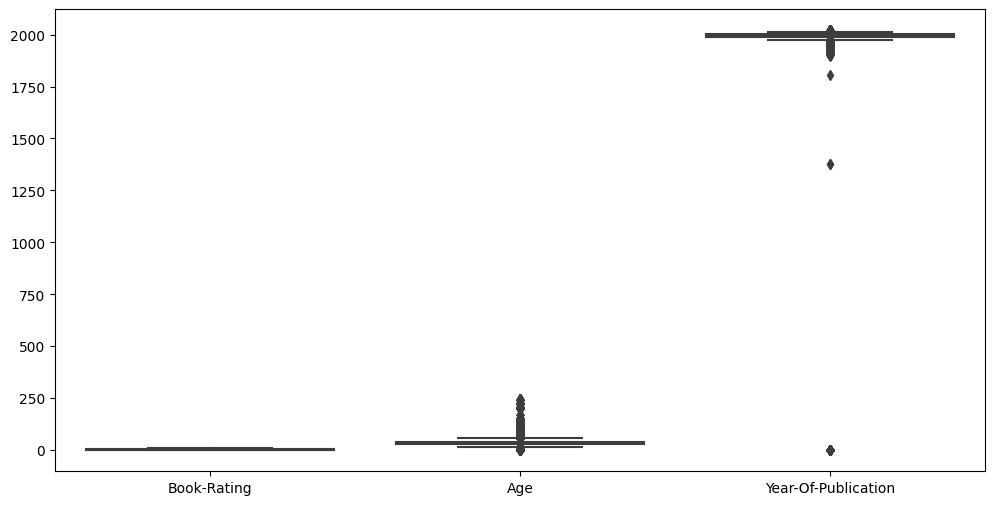

In [15]:
fig,ax = plt.subplots(figsize=(12,6))
sns.boxplot(data=train)

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 871393 entries, 0 to 871392
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   871393 non-null  object
 1   User-ID              871393 non-null  object
 2   Book-ID              871393 non-null  object
 3   Book-Rating          871393 non-null  int64 
 4   Age                  871393 non-null  int64 
 5   Location             871393 non-null  object
 6   Book-Title           871393 non-null  object
 7   Book-Author          871393 non-null  object
 8   Year-Of-Publication  871393 non-null  int64 
 9   Publisher            871393 non-null  object
dtypes: int64(3), object(7)
memory usage: 73.1+ MB


# EDA

나이별 분포

In [17]:
max_age = train['Age'].max() # Age 열의 최대값 찾기
min_age = train['Age'].min() # Age 열의 최소값 찾기

print('Maximum Age:', max_age)
print('Minimum Age:', min_age)

Maximum Age: 244
Minimum Age: 0


In [18]:
iid = 244
train[train["Age"] == iid]

,ID,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher
604950,TRAIN_604950,USER_63071,BOOK_055682,8,244,"stuttgart, baden-wuerttemberg, germany",Die Entdeckung der Currywurst.,Uwe Timm,2000,Dtv
604951,TRAIN_604951,USER_63071,BOOK_096177,0,244,"stuttgart, baden-wuerttemberg, germany",Das Blutgericht.,Kari KÃ?Â¶ster-LÃ?Â¶sche,2003,ECON-Taschenbuchverlag
604952,TRAIN_604952,USER_63071,BOOK_148270,0,244,"stuttgart, baden-wuerttemberg, germany",Dies Ist Nicht Mein Land,Fleischmann,-1,Wilhelm Heyne Verlag GmbH &amp; Co KG
604953,TRAIN_604953,USER_63071,BOOK_152432,0,244,"stuttgart, baden-wuerttemberg, germany",Wer Dornen sÃ?Â¤t.,Rebecca Ryman,2000,"Fischer (Tb.), Frankfurt"
604954,TRAIN_604954,USER_63071,BOOK_245261,8,244,"stuttgart, baden-wuerttemberg, germany",Who Put the Pizza in the Vcr: Laughing Your Wa...,Martha Bolton,1996,Gospel Light Pubns
604955,TRAIN_604955,USER_63071,BOOK_254526,0,244,"stuttgart, baden-wuerttemberg, germany",Die Tote im falschen Grab.,Ruth Rendell,2000,Goldmann
604956,TRAIN_604956,USER_63071,BOOK_266466,6,244,"stuttgart, baden-wuerttemberg, germany",Topkapi.,Eric Ambler,1978,Diogenes Verlag


In [19]:
train['Age'] = np.where((train['Age'] < 0) | (train['Age'] > 100), np.nan, train['Age'])

# 결측치를 평균값으로 대체하기
mean_Age = train['Age'].mean()
train['Age'] = train['Age'].fillna(mean_Age)

print(train)

                  ID     User-ID      Book-ID  Book-Rating   Age  \
0       TRAIN_000000  USER_00000  BOOK_044368            8  23.0   
1       TRAIN_000001  USER_00000  BOOK_081205            8  23.0   
2       TRAIN_000002  USER_00000  BOOK_086781            0  23.0   
3       TRAIN_000003  USER_00000  BOOK_098622            0  23.0   
4       TRAIN_000004  USER_00000  BOOK_180810            8  23.0   
...              ...         ...          ...          ...   ...   
871388  TRAIN_871388  USER_92096  BOOK_081138            0  34.0   
871389  TRAIN_871389  USER_92097  BOOK_258124            0  35.0   
871390  TRAIN_871390  USER_92098  BOOK_071848            0  45.0   
871391  TRAIN_871391  USER_92099  BOOK_252599            8  43.0   
871392  TRAIN_871392  USER_92100  BOOK_130798            0  35.0   

                                     Location  \
0            sackville, new brunswick, canada   
1            sackville, new brunswick, canada   
2            sackville, new brunswic

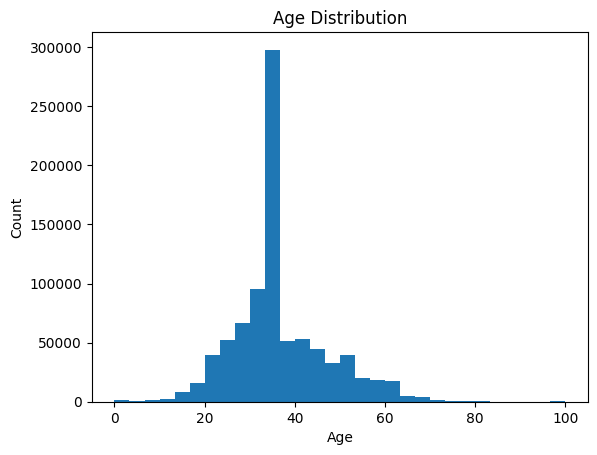

In [20]:
train['Age'].plot.hist(bins=30) # 히스토그램 그리기
plt.title('Age Distribution') # 그래프 제목 설정
plt.xlabel('Age') # x축 레이블 설정
plt.ylabel('Count') # y축 레이블 설정
plt.show() # 그래프 보이기

출판연도별 분포

In [21]:
year = -1
train[train["Year-Of-Publication"] == year]

,ID,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher
184,TRAIN_000184,USER_00049,BOOK_121460,0,37.0,"gaylord, michigan, usa",Bxc Blue Bay Mystery,Gertrude Cha Warner,-1,Scholastic Inc
186,TRAIN_000186,USER_00049,BOOK_175661,10,37.0,"gaylord, michigan, usa",Lighthouse Mystery,Gertrude C Warner,-1,Scholastic Inc
191,TRAIN_000191,USER_00049,BOOK_230275,0,37.0,"gaylord, michigan, usa",Mike's Mystery,Gertrude Cha Warner,-1,Scholastic Inc
231,TRAIN_000231,USER_00054,BOOK_122689,0,39.0,"spring, texas, usa",Charming Billy,Alice Mcdermott,-1,"Farrar, Straus Giroux"
290,TRAIN_000290,USER_00060,BOOK_165427,0,27.0,"los angeles, california, usa",Moon Palace,Paul Auster,-1,Faber Faber Inc
...,...,...,...,...,...,...,...,...,...,...
870700,TRAIN_870700,USER_92056,BOOK_093874,5,35.0,"leucadia, california, usa",High Ground,John Mcgahern,-1,Faber Faber Inc
870751,TRAIN_870751,USER_92058,BOOK_117063,0,24.0,"halifax, nova scotia, canada",Hotel Du Lac,Anita Brookner,-1,Penguin Putnam~trade
870776,TRAIN_870776,USER_92058,BOOK_181486,8,24.0,"halifax, nova scotia, canada",Laurels Kitchen a Handbook for Vegetarian Co,Laurel Robertson,-1,Bantam Doubleday Dell
870895,TRAIN_870895,USER_92080,BOOK_045027,10,35.0,"brookhaven, mississippi, usa",Best of Sisters In Crime,Marilyn Wallace,-1,Penguin Putnam~childrens Hc


In [22]:
train['Year-Of-Publication'] = np.where((train['Year-Of-Publication'] < 1950) | (train['Year-Of-Publication'] > 2010), np.nan, train['Year-Of-Publication'])

# 결측치를 평균값으로 대체하기
mean_Year = train['Year-Of-Publication'].mean()
train['Year-Of-Publication'] = train['Year-Of-Publication'].fillna(mean_Year)

print(train)

                  ID     User-ID      Book-ID  Book-Rating   Age  \
0       TRAIN_000000  USER_00000  BOOK_044368            8  23.0   
1       TRAIN_000001  USER_00000  BOOK_081205            8  23.0   
2       TRAIN_000002  USER_00000  BOOK_086781            0  23.0   
3       TRAIN_000003  USER_00000  BOOK_098622            0  23.0   
4       TRAIN_000004  USER_00000  BOOK_180810            8  23.0   
...              ...         ...          ...          ...   ...   
871388  TRAIN_871388  USER_92096  BOOK_081138            0  34.0   
871389  TRAIN_871389  USER_92097  BOOK_258124            0  35.0   
871390  TRAIN_871390  USER_92098  BOOK_071848            0  45.0   
871391  TRAIN_871391  USER_92099  BOOK_252599            8  43.0   
871392  TRAIN_871392  USER_92100  BOOK_130798            0  35.0   

                                     Location  \
0            sackville, new brunswick, canada   
1            sackville, new brunswick, canada   
2            sackville, new brunswic

<AxesSubplot:xlabel='Year-Of-Publication'>

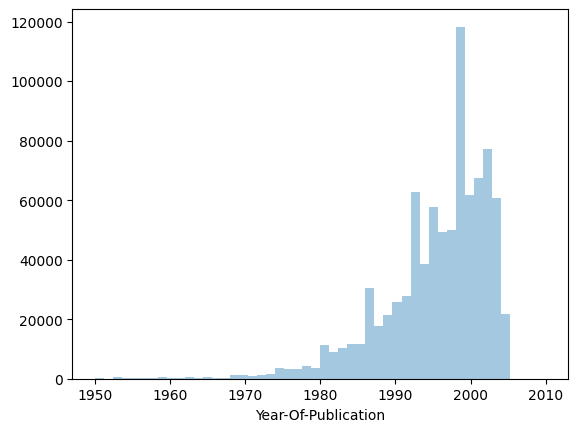

In [23]:
sns.distplot(train['Year-Of-Publication'], kde=False, bins=50)

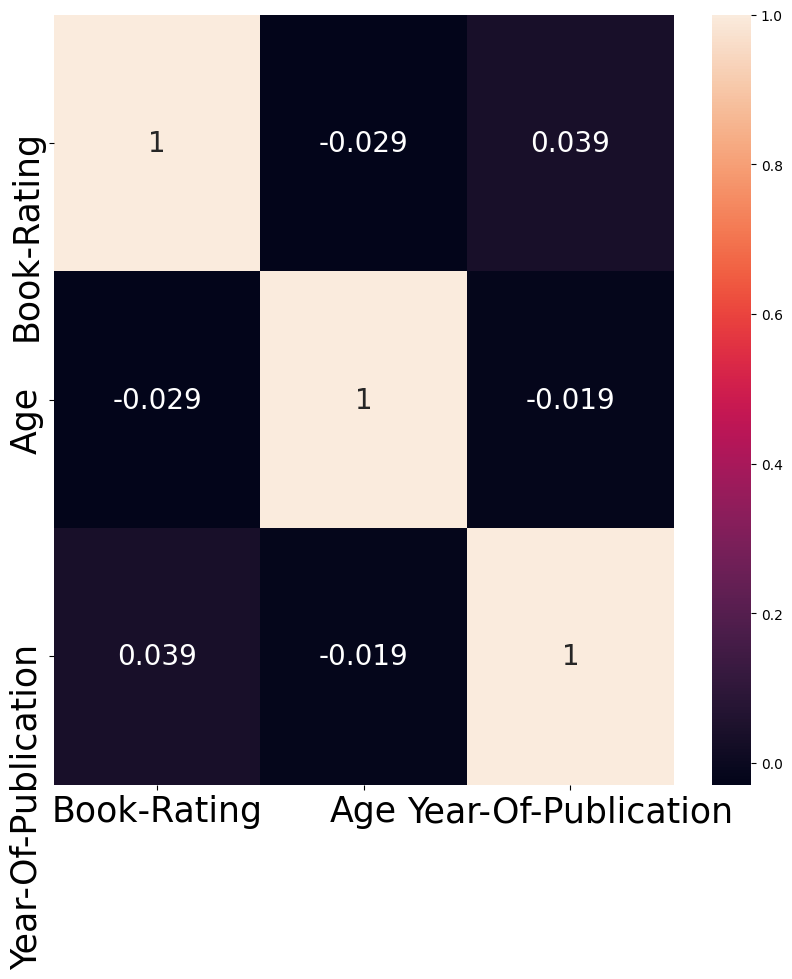

In [24]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(), annot=True, annot_kws={'size': 20}) #annot 크기 조정
plt.tick_params(labelsize=25)

In [25]:
train

,ID,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,TRAIN_000000,USER_00000,BOOK_044368,8,23.0,"sackville, new brunswick, canada",Road Taken,Rona Jaffe,2001.0,Mira
1,TRAIN_000001,USER_00000,BOOK_081205,8,23.0,"sackville, new brunswick, canada",Macbeth (New Penguin Shakespeare),William Shakespeare,1981.0,Penguin Books
2,TRAIN_000002,USER_00000,BOOK_086781,0,23.0,"sackville, new brunswick, canada",Waverley (Penguin English Library),Walter Scott,1981.0,Penguin Books
3,TRAIN_000003,USER_00000,BOOK_098622,0,23.0,"sackville, new brunswick, canada",Mother Earth Father Sky,Sue Harrison,1991.0,Avon
4,TRAIN_000004,USER_00000,BOOK_180810,8,23.0,"sackville, new brunswick, canada",She Who Remembers,Linda Lay Shuler,1989.0,Signet Book
...,...,...,...,...,...,...,...,...,...,...
871388,TRAIN_871388,USER_92096,BOOK_081138,0,34.0,"minneapolis, minnesota, usa",Healing Words: The Power of Prayer and the Pra...,Larry Dossey,1993.0,Harpercollins
871389,TRAIN_871389,USER_92097,BOOK_258124,0,35.0,"temple, texas, usa",The Salmon of Doubt: Hitchhiking the Galaxy On...,DOUGLAS ADAMS,2002.0,Harmony
871390,TRAIN_871390,USER_92098,BOOK_071848,0,45.0,"ottawa, ontario, canada",Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,2000.0,Thorndike Press
871391,TRAIN_871391,USER_92099,BOOK_252599,8,43.0,"maple grove, minnesota, usa",Heartbreak Hill: Anatomy of a Ryder Cup,Tim Rosaforte,1996.0,St Martins Pr


In [26]:
from geopy.geocoders import Nominatim
import pandas as pd

# 나라와 도시명이 저장된 데이터프레임 생성

# geopy의 Nominatim 객체 생성
geolocator = Nominatim(user_agent='my_application')

# 위도, 경도를 저장할 빈 리스트 생성
latitudes = []
longitudes = []

# 각 도시별 위도와 경도를 구하여 리스트에 저장
for index, row in train.iterrows():
    location = geolocator.geocode(row['City'] + ', ' + row['Country'])


ModuleNotFoundError: No module named 'geopy'

In [ ]:
import folium

# City, State, Country 열 추가하기
location_split = train['Location'].str.split(', ', expand=True)
train[['City', 'State', 'Country']] = location_split

# 지도에 마커 추가하기
m = folium.Map(location=[0, 0], zoom_start=2)
for i, row in train.iterrows():
    city = row['City']
    state = row['State']
    country = row['Country']
    tooltip = f"{city}, {state}, {country}"
    location = f"{city}, {country}"
    try:
        geocode = geolocator.geocode(location)
        latitude = geocode.latitude
        longitude = geocode.longitude
        folium.Marker(
            location=[latitude, longitude],
            tooltip=tooltip
        ).add_to(m)
    except:
        pass

m


# 추천시스템

In [27]:
df_valid = train[train["ID"].notnull()].drop_duplicates()

df_valid.shape

(871393, 10)

In [28]:
df = df_valid[["ID", "Book-ID", "Book-Rating"]].drop_duplicates()
print(df.shape)
df.head()

(871393, 3)


,ID,Book-ID,Book-Rating
0,TRAIN_000000,BOOK_044368,8
1,TRAIN_000001,BOOK_081205,8
2,TRAIN_000002,BOOK_086781,0
3,TRAIN_000003,BOOK_098622,0
4,TRAIN_000004,BOOK_180810,8


In [29]:
r_min = df["Book-Rating"].min()
r_max = df["Book-Rating"].max()
r_min, r_max

(0, 10)

In [30]:
reader = Reader(rating_scale=(r_min, r_max))
reader

In [31]:
data = Dataset.load_from_df(
    df[["ID", "Book-ID", "Book-Rating"]], 
    reader)
data

In [32]:
from surprise.model_selection import train_test_split

X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

In [33]:
X_train.n_users, X_train.n_items, X_train.n_ratings

(697114, 214412, 697114)

In [34]:
X_train

In [35]:
type(X_test), len(X_test)

(list, 174279)

# 사용자기반 협업필터링

In [ ]:
from surprise.prediction_algorithms.knns import KNNBasic
# model

knn = KNNBasic(name="cosine", user_base=True)
knn.fit(trainset)

In [ ]:
predictions_knn = knn.test(trainset)

In [ ]:
validset[3]

In [ ]:
predictions_knn[3]

In [ ]:
df["Book-Rating"].describe()

In [ ]:
accuracy.rmse(predictions_knn)

In [ ]:
df.sample()

In [ ]:
iid = "BOOK_011665"
df[df["Book-ID"] == iid]

In [ ]:
uid = 'USER_44609'
iid = "BOOK_011665"
df[(df["User-ID"] == uid) & (df["Book-ID"] == iid)]

# 아이템기반 협업필터링

In [ ]:
knni = KNNBasic(name="cosine", user_base=False)
knni.fit(trainset)

In [ ]:
predictions_item = knni.test(validset)

In [ ]:
accuracy.rmse(predictions_item)

In [ ]:
df.iloc[3]

# SVD

In [36]:
svd = SVD(random_state=42)
svd.fit(X_train)

In [37]:
X_test = [(f"TEST_{uid[6:]}", iid, rating) for uid, iid, rating in X_test]
X_test

[('TEST_078244', 'BOOK_041738', 0.0),
 ('TEST_858428', 'BOOK_209704', 0.0),
 ('TEST_516745', 'BOOK_064606', 0.0),
 ('TEST_185110', 'BOOK_080098', 9.0),
 ('TEST_263788', 'BOOK_112483', 0.0),
 ('TEST_504425', 'BOOK_001061', 0.0),
 ('TEST_121719', 'BOOK_266334', 0.0),
 ('TEST_602125', 'BOOK_251217', 10.0),
 ('TEST_101696', 'BOOK_163736', 7.0),
 ('TEST_569292', 'BOOK_143269', 7.0),
 ('TEST_634215', 'BOOK_174481', 0.0),
 ('TEST_677451', 'BOOK_073539', 0.0),
 ('TEST_335614', 'BOOK_236794', 0.0),
 ('TEST_550089', 'BOOK_184597', 0.0),
 ('TEST_035323', 'BOOK_001634', 0.0),
 ('TEST_326534', 'BOOK_103689', 0.0),
 ('TEST_724618', 'BOOK_268452', 0.0),
 ('TEST_500265', 'BOOK_050695', 9.0),
 ('TEST_672474', 'BOOK_116875', 0.0),
 ('TEST_689743', 'BOOK_150281', 0.0),
 ('TEST_682400', 'BOOK_147882', 0.0),
 ('TEST_834424', 'BOOK_202114', 8.0),
 ('TEST_358803', 'BOOK_134711', 9.0),
 ('TEST_638566', 'BOOK_044367', 9.0),
 ('TEST_235869', 'BOOK_086710', 0.0),
 ('TEST_067488', 'BOOK_268823', 0.0),
 ('TEST_089

In [38]:
predictions_svd = svd.test(X_test)
predictions_svd

[Prediction(uid='TEST_078244', iid='BOOK_041738', r_ui=0.0, est=2.576516765302445, details={'was_impossible': False}),
 Prediction(uid='TEST_858428', iid='BOOK_209704', r_ui=0.0, est=2.15857010802133, details={'was_impossible': False}),
 Prediction(uid='TEST_516745', iid='BOOK_064606', r_ui=0.0, est=2.823290021431215, details={'was_impossible': False}),
 Prediction(uid='TEST_185110', iid='BOOK_080098', r_ui=9.0, est=3.706308715875484, details={'was_impossible': False}),
 Prediction(uid='TEST_263788', iid='BOOK_112483', r_ui=0.0, est=2.9559690627755004, details={'was_impossible': False}),
 Prediction(uid='TEST_504425', iid='BOOK_001061', r_ui=0.0, est=3.41366824667219, details={'was_impossible': False}),
 Prediction(uid='TEST_121719', iid='BOOK_266334', r_ui=0.0, est=3.3506819440099678, details={'was_impossible': False}),
 Prediction(uid='TEST_602125', iid='BOOK_251217', r_ui=10.0, est=2.316109149484106, details={'was_impossible': False}),
 Prediction(uid='TEST_101696', iid='BOOK_163736

In [39]:
predictions_svd[1]

Prediction(uid='TEST_858428', iid='BOOK_209704', r_ui=0.0, est=2.15857010802133, details={'was_impossible': False})

In [40]:
accuracy.rmse(predictions_svd)

RMSE: 3.8103


3.810328755850202

In [ ]:
from surprise.model_selection import GridSearchCV, cross_validate

param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}

gridcv = GridSearchCV(algo_class=SVD, 
                      param_grid=param_grid, 
                      measures=["rmse"], cv=3)
gridcv.fit(data)

In [ ]:
gridcv.best_estimator

In [ ]:
gridcv.best_params["rmse"]

In [ ]:
gridcv.best_score

In [ ]:
gridcv.algo_class

In [ ]:
best_svd = gridcv.best_estimator["rmse"]
best_svd.fit(X_train)

In [ ]:
predictions_bsvd = best_svd.test(X_test)

In [ ]:
predictions_bsvd[0]

In [ ]:
accuracy.rmse(predictions_bsvd)

In [ ]:
df_pred_svd = pd.DataFrame(predictions_bsvd)
df_pred_svd.head()

In [ ]:
y_pred_svd = df_pred_svd["est"].unique()
y_pred_svd

In [ ]:
df_submit = pd.read_csv(f"{base_path}/sample_submission.csv", index_col='ID')
df_submit.head()

In [ ]:
df_submit.shape

In [ ]:
df_submit.head()

In [ ]:
submission.shape

In [ ]:
df_submit.shape

In [ ]:
cv_result = cross_validate(best_svd, data, measures=["rmse"], n_jobs=2, verbose=True)

In [ ]:
pd.DataFrame(cv_result)

In [ ]:
def get_top_n(predictions, n=10):
    # 각 사용자의 예측데이터를 defaultdict에 저장
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # 정렬 후 Top N 개만 저장
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
top_num = get_top_n(predictions_bsvd, 10)

In [ ]:
df_cust_recomm = pd.DataFrame(top_num.items())

In [ ]:
df_cust_recomm.head()

In [ ]:
stock_desc = df_valid[
    ["ID", "Book-Rating"]].drop_duplicates("ID").set_index("ID")
stock_desc

In [ ]:
df_submit = pd.read_csv(f"{base_path}/sample_submission.csv")
df_submit

In [ ]:
stock_desc.to_csv(file_name)
pd.read_csv(file_name)

In [ ]:
file_name = f"{base_path}/submit.csv"
file_name

In [ ]:
from google.colab import files

files.download(file_name)

In [ ]:
train[categorical_feature] = train[categorical_feature].astype("category")
test[categorical_feature] = test[categorical_feature].astype("category")

train.info(), test.info()

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train[categorical_feature] = oe.fit_transform(train[categorical_feature])
test[categorical_feature] = oe.transform(test[categorical_feature])

In [ ]:
from sklearn.model_selection import train_test_split

# X_train, X_valid, y_train, y_valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

In [ ]:
X = train.drop(columns="Book-Rating")
y = train["Book-Rating"]

X.shape, y.shape

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size = 0.1, random_state=42
)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

In [ ]:
X_test = test
X_test.shape

In [ ]:
import xgboost as xgb

model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=250, 
                             max_depth=3,
                             random_state=42, 
                             n_jobs=-1)
                             
model_xgb

In [ ]:
dtrain = xgb.DMatrix(X, label=y)

In [ ]:
from xgboost.callback import EarlyStopping
# fit
es = xgb.callback.EarlyStopping(
    rounds=2,
    save_best=True,
    maximize=False,
    data_name="validation_0",
    metric_name="rmse",
)

model_xgb.fit(X_train, y_train, 
              eval_set=[(X_valid, y_valid)], callbacks=[es])

In [ ]:
y_valid_predict = model_xgb.predict(X_valid)
y_valid_predict[:5]

In [ ]:
fi = pd.Series(model_xgb.feature_importances_)
fi.index = model_xgb.feature_names_in_
fi.nlargest(20).plot.barh()

In [ ]:
xgb.plot_tree(model_xgb, num_trees=0)
fig = plt.gcf()
fig.set_size_inches(30, 20)

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_valid, y_valid_predict)

In [ ]:
score_xgb = model_xgb.score(X_valid, y_valid)
score_xgb

In [ ]:
X_test.shape

In [ ]:
y_pred_xgb = model_xgb.predict(X_test)
y_pred_xgb[:5]

In [ ]:
df_submit = pd.read_csv(f"{base_path}/sample_submission.csv")
df_submit.head()

In [ ]:
df_submit["Book-Rating"] = abs(y_pred_xgb)
df_submit.head(2)

In [ ]:
file_name = f"{base_path}/submit.csv"
file_name